In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import sys
sys.path.append("/home/konajain/code/lobSimulations")
from hawkes import dataLoader

In [26]:
ric = "AMZN.OQ"
sizes = {}
for d in pd.date_range(dt.date(2019,1,2), dt.date(2019,3,31)):
    try:
        data = pd.read_csv("/SAN/fca/Konark_PhD_Experiments/extracted/"+ric+"_"+ d.strftime("%Y-%m-%d") +"_12D.csv")
    except: 
        continue
    df = data.groupby("event").Size.apply(list).to_dict()
    for k, v in df.items():
        if "Ask" in k: k = k.replace("Ask", "Bid")
        sizes[k] = sizes.get(k, []) + v

/home/konajain/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
sizes.keys()

dict_keys(['co_deep_Bid', 'co_top_Bid', 'lo_deep_Bid', 'lo_inspread_Bid', 'lo_top_Bid', 'mo_Bid'])

In [28]:
import copy
params = {}

 #,200,500]
for c in sizes.keys():
    roundNums = [1,10,50,100]
    if "mo" in c: roundNums += [200]
    diracs = {}
    size, freq = np.unique(sizes[c], return_counts = True)
    size_freq = np.vstack([size, freq])
    size_freq_copy = copy.deepcopy(size_freq)
    for num in roundNums:
        idx = np.where(size_freq[0,:] == num)[0][0]
        diracs[num] = size_freq_copy[1,idx]/np.sum(freq)
        size_freq_copy[1,idx] = size_freq_copy[1, idx+1]
    p = np.sum(size_freq_copy[1,:])/np.sum(np.multiply(size_freq_copy[0,:], size_freq_copy[1,:]))
    p_dirac = []
    totalProb = sum([p*(1-p)**(num-1) for num in roundNums])
    totalObsProb = sum(list(diracs.values()))
    for num in roundNums:
        prob = p*(1-p)**(num-1)
        p_dirac.append((num, np.max([0, (diracs[num]*(totalProb - 1)/(totalObsProb - 1)) - prob])))
    params[c] = [p, p_dirac]

In [29]:
params

{'co_deep_Bid': [0.058643370885284464,
  [(1, 0.03566540471741698),
   (10, 0.0),
   (50, 0.05387916908292841),
   (100, 0.47387760600144424)]],
 'co_top_Bid': [0.057368760221804815,
  [(1, 0.05409427856967469),
   (10, 0.01083980945682534),
   (50, 0.17856959290021032),
   (100, 0.5305337300263281)]],
 'lo_deep_Bid': [0.05958213706845956,
  [(1, 0.057446825731119984),
   (10, 0.011125136923873007),
   (50, 0.01933201666829289),
   (100, 0.6348278415533004)]],
 'lo_inspread_Bid': [0.038562301495905914,
  [(1, 0.1168367454898604),
   (10, 0.0557382431709154),
   (50, 0.3467325997346703),
   (100, 0.8833905166426477)]],
 'lo_top_Bid': [0.05329616963733641,
  [(1, 0.19425540200523306),
   (10, 0.025295856444822386),
   (50, 0.020497438365610236),
   (100, 0.4307699176008908)]],
 'mo_Bid': [0.032949075097457925,
  [(1, 0.29374511617853377),
   (10, 0.0718169215529087),
   (50, 0.055061736880763365),
   (100, 0.15039996187749854),
   (200, 0.005369246722650729)]]}

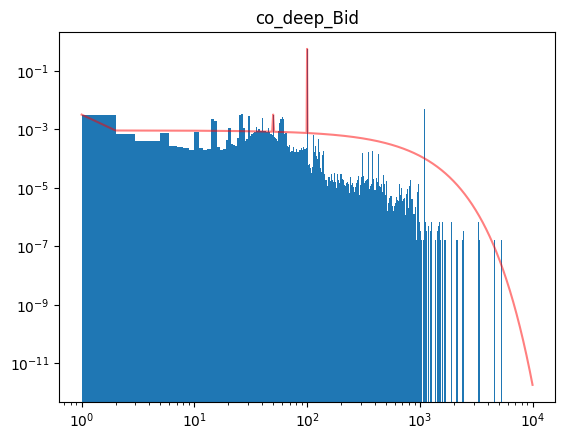

MemoryError: Unable to allocate 140. MiB for an array with shape (18290926, 1) and data type int64

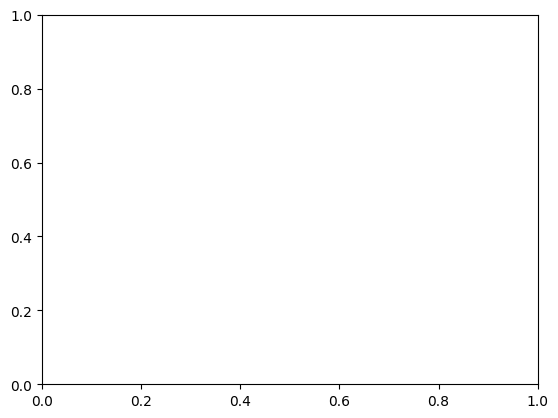

In [33]:
hists = {}
for k, v in sizes.items():
    p , dd  = params[k]
    pi = np.array([p*(1-p)**k for k in range(1,10000)])
    # pi = pi*(1-sum([d[1] for d in dd]))/sum(pi)
    for i, p_i in dd:
                        pi[i-1] = p_i + pi[i-1]
    pi = pi/sum(pi)
    fig = plt.figure()
    n, bins, _ = plt.hist(v, bins = np.arange(1,10000), density = True)
    plt.plot(np.arange(1,10000), pi, color = "red", alpha = 0.5)
    hists[k] = (n, bins)
    plt.title(k)    
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

In [30]:
# ric= "INTC.OQ"
queues = {}
for d in pd.date_range(dt.date(2019,1,2), dt.date(2019,3,31)):
    try:
        data = pd.read_csv("/SAN/fca/Konark_PhD_Experiments/extracted/"+ric+"_"+ d.strftime("%Y-%m-%d") +"_12D.csv")
    except: 
        continue
    queues["Ask_touch"] = np.append(queues.get("Ask_touch", []) , data["Ask Size 1"].values)
    queues["Ask_deep"] = np.append(queues.get("Ask_deep", []) , data["Ask Size 2"].values)
    queues["Ask_touch"] = np.append(queues.get("Ask_touch", []) , data["Bid Size 1"].values)
    queues["Ask_deep"] = np.append(queues.get("Ask_deep", []) , data["Bid Size 2"].values)

/home/konajain/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
import copy
params = {}
sizes = copy.deepcopy(queues)
 #,200,500]
for c in sizes.keys():
    roundNums = [1,10,100, 500, 1000]
    if "mo" in c: roundNums += [200]
    diracs = {}
    size, freq = np.unique(sizes[c], return_counts = True)
    size_freq = np.vstack([size, freq])
    size_freq_copy = copy.deepcopy(size_freq)
    for num in roundNums:
        idx = np.where(size_freq[0,:] == num)[0][0]
        diracs[num] = size_freq_copy[1,idx]/np.sum(freq)
        size_freq_copy[1,idx] = size_freq_copy[1, idx+1]
    p = np.sum(size_freq_copy[1,:])/np.sum(np.multiply(size_freq_copy[0,:], size_freq_copy[1,:]))
    p_dirac = []
    totalProb = sum([p*(1-p)**(num-1) for num in roundNums])
    totalObsProb = sum(list(diracs.values()))
    for num in roundNums:
        prob = p*(1-p)**(num-1)
        p_dirac.append((num, np.max([0, (diracs[num]*(totalProb - 1)/(totalObsProb - 1)) - prob])))
    params[c] = [p, p_dirac]

In [32]:
params

{'Ask_touch': [0.010569068336116975,
  [(1, 0.11631071538074542),
   (10, 0.03942041559910066),
   (100, 0.2911463764655624),
   (500, 0.0015346534902328998),
   (1000, 0.0008246596078224383)]],
 'Ask_deep': [0.014639327119686312,
  [(1, 0.10910251548637026),
   (10, 0.03075549949138249),
   (100, 0.27677505509194006),
   (500, 0.0016563689305610241),
   (1000, 0.0012702383211743262)]]}

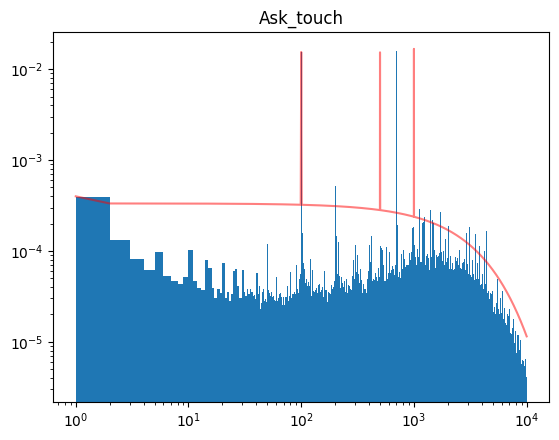

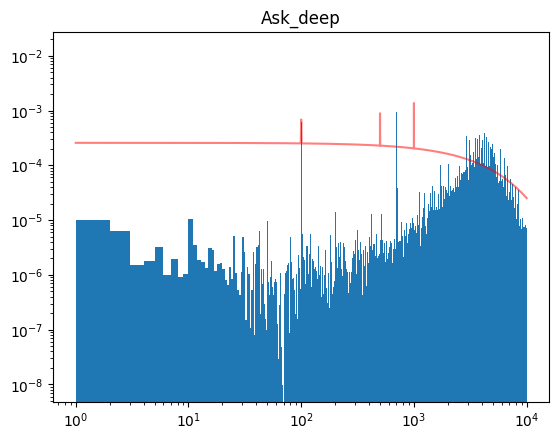

In [11]:
hists = {}
for k, v in sizes.items():
    p , dd  = params[k]
    pi = np.array([p*(1-p)**k for k in range(1,10000)])
    # pi = pi*(1-sum([d[1] for d in dd]))/sum(pi)
    for i, p_i in dd:
                        pi[i-1] = p_i + pi[i-1]
    pi = pi/sum(pi)
    fig = plt.figure()
    n, bins, _ = plt.hist(v, bins = np.arange(1,10000), density = True)
    plt.plot(np.arange(1,10000), pi, color = "red", alpha = 0.5)
    hists[k] = (n, bins)
    plt.title(k)    
    plt.xscale("log")
    plt.yscale("log")
    plt.show()